# SAM Inference

- **Device**: Ascend (set in MindSpore context)
- **Precision**: floats in **fp16**, sizes in **int32**
- **Overlay**: `uint8` RGBA for Matplotlib compatibility

This notebook shows a minimal, step-by-step pipeline with a few intermediate outputs.

In [1]:
from pathlib import Path
import requests

def download_image(url: str, save_dir: str = ".") -> str:
    """
    从 URL 下载图片到 save_dir，返回本地文件路径（字符串）。
    """
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)

    filename = (url.rsplit("/", 1)[-1] or "image.jpg")
    dst = save_path / filename

    try:
        resp = requests.get(url, timeout=30)
        resp.raise_for_status()
        dst.write_bytes(resp.content)
        print(f"示例图片已成功下载到: {dst}")
        return str(dst)
    except Exception as e:
        print(f"下载示例图片时出错: {e}")
        return ""

# 使用示例
image_url = "https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg"
downloaded_image = download_image(image_url)
if downloaded_image:
    print(f"示例图片已保存为: {downloaded_image}")

示例图片已成功下载到: dog.jpg
示例图片已保存为: dog.jpg


In [2]:
import os
from mindnlp.transformers import SamModel, SamProcessor
import mindspore as ms

MODEL_ID = "facebook/sam-vit-base"
CACHE_DIR = os.path.expanduser("~/.cache/mindnlp")  # or "/tmp/mindnlp"

os.makedirs(CACHE_DIR, exist_ok=True)

# (optional) align other libs to the same cache location
os.environ["HF_HOME"] = CACHE_DIR
os.environ["MINDNLP_HOME"] = CACHE_DIR

print("Loading SAM (fp16 weights)...")
processor = SamProcessor.from_pretrained(MODEL_ID, cache_dir=CACHE_DIR)
model = SamModel.from_pretrained(MODEL_ID, ms_dtype=ms.float16, cache_dir=CACHE_DIR)
model.set_train(False)
print("Loaded!")


[WARNING] DEVICE(11334,e7fffbe4c020,python):2025-11-05-10:37:08.003.252 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclprofGetSupportedFeaturesV2 failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libmsprofiler.so: undefined symbol: aclprofGetSupportedFeaturesV2
[WARNING] DEVICE(11334,e7fffbe4c020,python):2025-11-05-10:37:08.003.384 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclrtEventGetTimestamp failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libascendcl.so: undefined symbol: aclrtEventGetTimestamp
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  

Loading SAM (fp16 weights)...


[WARNING] DEVICE(11334,e7fffbe4c020,python):2025-11-05-10:37:27.209.516 [mindspore/ccsrc/plugin/res_manager/ascend/mem_manager/ascend_memory_adapter.cc:123] Initialize] Free memory size is less than half of total memory size.Device 0 Device MOC total size:24823529472 Device MOC free size:11953582080 may be other processes occupying this card, check as: ps -ef|grep python
2025-11-05 10:37:44.166174: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute T which is not in the op definition: Op<name=StatelessRandomNormalV2; signature=shape:Tshape, key:uint64, counter:uint64, alg:int32 -> output:dtype; attr=dtype:type,default=DT_FLOAT,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT, DT_DOUBLE]; attr=Tshape:type,default=DT_INT32,allowed=[DT_INT32, DT_INT64]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node StatelessRandomNormalV2}}


Loaded!


Image size: (800, 534) | BBox: [0, 217, 450, 800]


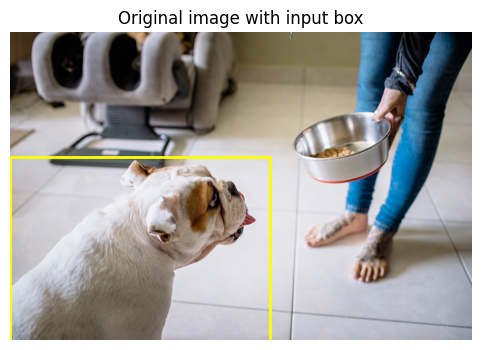

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# %% [config] image path and box
img_path = "dog.jpg"   # <-- change to your image path
assert os.path.exists(img_path), f"Image not found: {img_path}"

# Custom bbox in original image coordinates [x1,y1,x2,y2]
bbox = [0, 217, 450, 800]  # <-- change if needed, ensure in-bounds
bbox = [int(x) for x in bbox]  # keep as Python ints for clarity

image = Image.open(img_path).convert("RGB")
W, H = image.size
print("Image size:", (W, H), "| BBox:", bbox)

plt.figure(figsize=(6,4))
plt.imshow(image)
import matplotlib.patches as patches
ax = plt.gca()
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                         linewidth=2, edgecolor='yellow', facecolor='none')
ax.add_patch(rect)
plt.title("Original image with input box")
plt.axis("off")
plt.show()

In [4]:
# %% [step 1] preprocessing (processor handles scaling & padding)
inputs = processor(images=image, input_boxes=[[bbox]], return_tensors="ms")

DTYPE_FP = ms.float16
DTYPE_INT = ms.int32
# force our target precisions
inputs["pixel_values"] = inputs["pixel_values"].astype(ms.float16)            # fp16
if "input_boxes" in inputs:
    inputs["input_boxes"] = inputs["input_boxes"].astype(ms.float16)          # fp16
inputs["original_sizes"] = inputs["original_sizes"].astype(ms.int32)        # int32
inputs["reshaped_input_sizes"] = inputs["reshaped_input_sizes"].astype(ms.int32)  # int32

for k, v in inputs.items():
    print(f"{k}: shape={tuple(v.shape)}, dtype={v.dtype}")

pixel_values: shape=(1, 3, 1024, 1024), dtype=mindspore.float16
original_sizes: shape=(1, 2), dtype=mindspore.int32
reshaped_input_sizes: shape=(1, 2), dtype=mindspore.int32
input_boxes: shape=(1, 1, 4), dtype=mindspore.float16


pred_masks: (1, 1, 3, 256, 256)
iou_scores: (1, 1, 3)


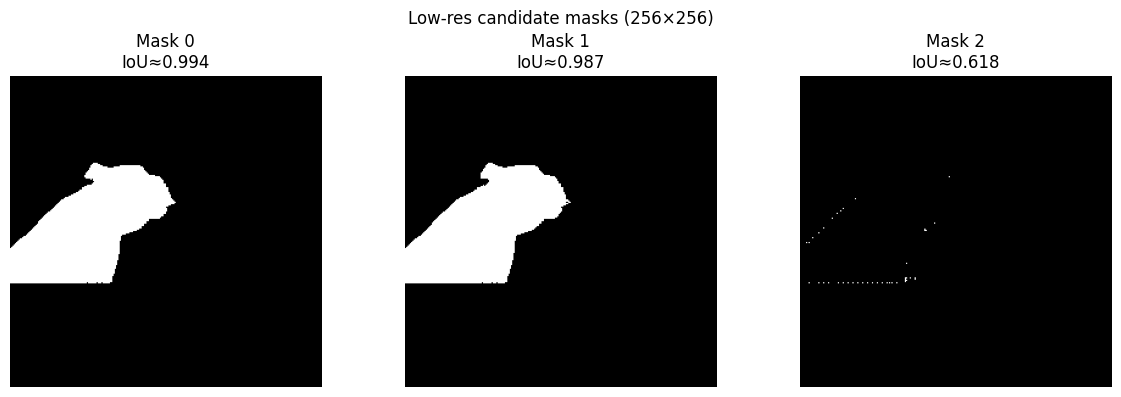

In [5]:
# %% [step 2] forward pass

import mindnlp.core.nn.functional as F

_orig_interpolate = F.interpolate

def _interpolate_patch(x, size=None, scale_factor=None, mode='nearest',
                       align_corners=None, recompute_scale_factor=None, antialias=False):
    # 仅在 Ascend + 1D 线性插值时绕过 ResizeLinear1D
    if (ms.get_context("device_target") == "Ascend"
        and mode == 'linear'
        and size is not None
        and getattr(x, "ndim", None) == 3):
        # 假定 x 形状为 (N, C, L)，沿最后一维 L 做插值
        target = int(size[0] if isinstance(size, (tuple, list)) else size)
        # (N, C, L) -> (N, C, L, 1)
        y = _orig_interpolate(x.expand_dims(3), size=(target, 1), mode='bilinear', align_corners=False)
        # (N, C, target, 1) -> (N, C, target)
        return y.squeeze(axis=3)
    # 其他情况按原实现
    return _orig_interpolate(x, size, scale_factor, mode, align_corners, recompute_scale_factor)

F.interpolate = _interpolate_patch

outputs = model(**inputs)

# keep tensors in our desired dtypes
pred_masks = outputs.pred_masks.astype(DTYPE_FP)  # (B, boxes, M, 256, 256)
iou_scores = outputs.iou_scores.astype(DTYPE_FP)  # (B, boxes, M)

print("pred_masks:", tuple(pred_masks.shape))
print("iou_scores:", tuple(iou_scores.shape))

# preview low-res candidate masks (M masks at 256x256)
pm = pred_masks[0, 0].asnumpy()  # (M, 256, 256)
scores_np = iou_scores[0, 0].asnumpy()
M = pm.shape[0]

fig, axes = plt.subplots(1, M, figsize=(4*M, 4))
if M == 1:
    axes = [axes]
for i in range(M):
    axes[i].imshow(pm[i] > 0, cmap="gray")
    axes[i].set_title(f"Mask {i}\nIoU≈{float(scores_np[i]):.3f}")
    axes[i].axis("off")
plt.suptitle("Low-res candidate masks (256×256)")
plt.tight_layout()
plt.show()

In [6]:
# %% [step 3] post-process to original size & pick best
import numpy as np

upsampled_list = processor.post_process_masks(
    pred_masks,
    inputs["original_sizes"],        # [[H_orig, W_orig]] (int32)
    inputs["reshaped_input_sizes"],  # [[H_in,   W_in  ]] (int32)
)

m = upsampled_list[0]                 # (boxes, M, H, W) or (M, H, W)
if m.ndim == 4:
    m = m[0]
m = m.astype(DTYPE_FP)                # ensure fp16 tensor

scores_np = iou_scores[0, 0].asnumpy().astype(np.float16)
best_idx = int(np.int32(np.argmax(scores_np)))
best_score = float(np.float16(scores_np[best_idx]))
best_mask = (m[best_idx].asnumpy() > 0)  # (H, W) bool

print("Best index:", best_idx, "| IoU:", best_score)
print("Best mask shape (H,W):", best_mask.shape)

Best index: 0 | IoU: 0.994140625
Best mask shape (H,W): (534, 800)


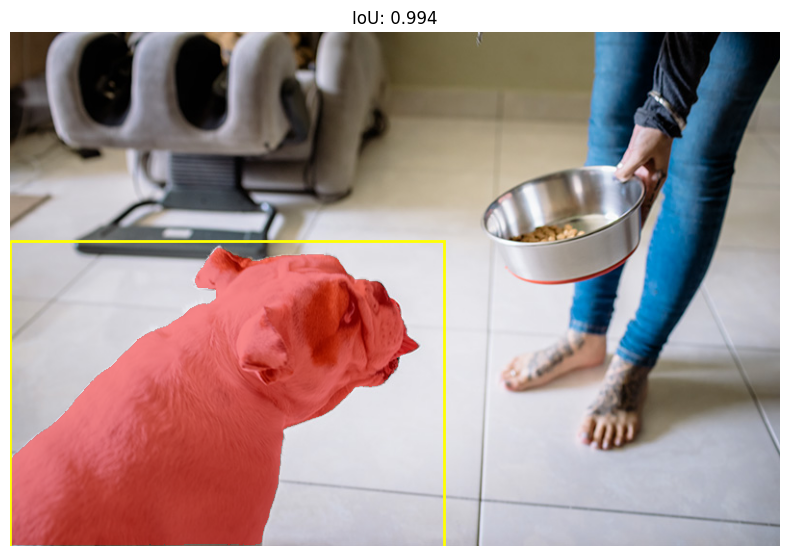

Saved: dog_segmentation_result.png


In [7]:
# %% [step 4] visualize overlay (uint8 RGBA for Matplotlib)
H, W = best_mask.shape
overlay = np.zeros((H, W, 4), dtype=np.uint8)
overlay[best_mask] = np.array([255, 0, 0, 115], dtype=np.uint8)  # ~45% alpha

plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.imshow(overlay)
import matplotlib.patches as patches
x1, y1, x2, y2 = bbox
rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=2, edgecolor='yellow', facecolor='none')
plt.gca().add_patch(rect)
plt.title(f"IoU: {best_score:.3f}")
plt.axis("off")
plt.tight_layout()
save_path = "dog_segmentation_result.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", save_path)